# AdvancedHMC.jl and DynamicHMC.jl for Turchin's regularisation algorithm.

In [1]:
include("../src/StatReg.jl")
using .StatReg

using Plots
plotly()
gr(size=(500,500), html_output_format=:png)

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300));

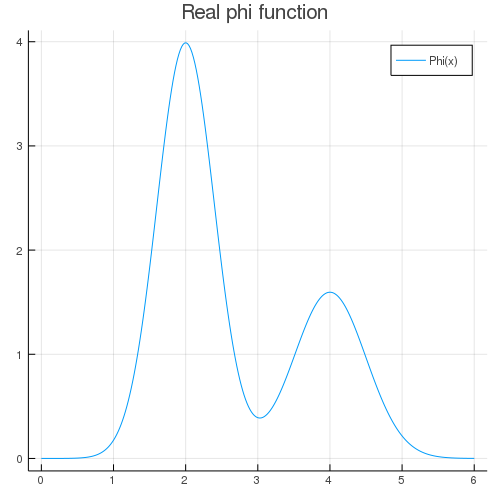

In [2]:
plot(x, phi.(x), title="Real phi function", label="Phi(x)")

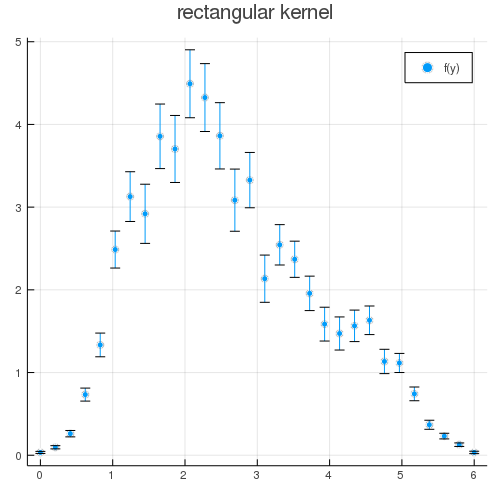

In [3]:
using QuadGK
kernel_name = "rectangular"
kernel(x::Real, y::Real) = getOpticsKernels(kernel_name)(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.1*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
# Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise;
plot(y, f, title="$(kernel_name) kernel", label="f(y)", seriestype=:scatter, yerr=sig)
# savefig("integrated_$(kernel_name).png")

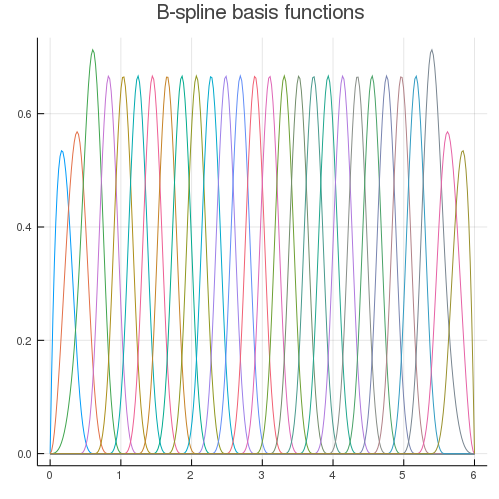

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/cubic_spline.jl:103
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/cubic_spline.jl:117


In [4]:
basis = CubicSplineBasis(y, "dirichlet");
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.(x), title="B-spline basis functions", legend=false, show = true)
end
display(p)
# savefig("basis.png")
Omega = omega(basis, 2);

In [5]:
result = solve(
    basis, f, sig, kernel, y,
    Analytically(), User([0.01])
    );
result_BAT = solve(
    basis, f, sig, kernel, y,
    BATSampling(), User([0.01])
    );
result_AHMC = solve(
    basis, f, sig, kernel, y,
    AHMCSampling(), User([0.01])
    );
result_DHMC = solve(
    basis, f, sig, kernel, y,
    DHMCSampling(), User([0.01])
    );

┌ Info: Checking data
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:29
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/utils.jl:20
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/utils.jl:32
┌ Info: Finding optimal alpha
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:35
┌ Info: Optimal alpha found
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:37
┌ Info: Starting solution
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:54
┌ Info: Solved analytically
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/analytically.jl:5
┌ Info: Checking data
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:29
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents

# AdvancedHMC.jl

```julia
mutable struct AHMCSampling<:AlgoType
    log_data_distribution::Union{Function, Nothing}
    nchains::Int
    nsamples::Int
    n_adapts::Int

    AHMCSampling(log_data_distribution::Union{Function, Nothing}=nothing,
    nchains::Int=1,
    nsamples::Int=10000,
    n_adapts::Int=100
    ) = new(log_data_distribution, nchains, nsamples, n_adapts)
end

function _solve(algo::AHMCSampling, alphas::AlphasType, omegas::Union{Array{Array{T, 2}, 1}, Nothing} where T<:Real, B, b, phi_bounds::PhiBounds, basis::Basis)
    sig = transpose(alphas.alphas) * omegas
    posterior = let algo=algo, sig=sig, phi_bounds=phi_bounds
        phi -> begin
            prior_log = -1/2 * transpose(phi) * sig * (phi)
            bounds_correction = log_bounds_correction(phi, phi_bounds)
            likelihood_log = algo.log_data_distribution(phi)
            return prior_log + likelihood_log + bounds_correction
        end
    end
    metric = DiagEuclideanMetric(length(phi_bounds.initial))
    hamiltonian = Hamiltonian(metric, posterior, ForwardDiff)
    initial_ϵ = find_good_eps(hamiltonian, phi_bounds.initial)
    integrator = Leapfrog(initial_ϵ)
    proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
    adaptor = StanHMCAdaptor(Preconditioner(metric), NesterovDualAveraging(0.8, integrator))
    @info "Starting sampling"
    res = AdvancedHMC.sample(
        hamiltonian, proposal, phi_bounds.initial,
        algo.nsamples, adaptor, algo.n_adapts; progress=false
        )
    samples = res[1]
    coeff = [mean(getindex.(samples, x)) for x in eachindex(samples[1])]
    errors = [cov(getindex.(samples, x)) for x in eachindex(samples[1])]
    @info "Solved with AHMC.jl"
    return PhiVec(coeff, basis, errors, alphas.alphas)
end

```

# DynamicHMC.jl

```julia
mutable struct DHMCSampling<:AlgoType
    log_data_distribution::Union{Function, Nothing}
    nchains::Int
    nsamples::Int

    DHMCSampling(log_data_distribution::Union{Function, Nothing}=nothing,
    nchains::Int=1,
    nsamples::Int=10000
    ) = new(log_data_distribution, nchains, nsamples)
end

struct TurchinProblem
    algo::DHMCSampling
    sig::Matrix
    phi_bounds::PhiBounds
end

function (problem::TurchinProblem)(θ)
    @unpack phi = θ
    @unpack algo, sig, phi_bounds = problem
    mu = phi_bounds.initial
    prior_log = -1/2 * transpose(phi - mu) * sig * (phi - mu)
    likelihood_log = algo.log_data_distribution(phi)
    bounds_correction = log_bounds_correction(phi, phi_bounds)
    return prior_log + likelihood_log + bounds_correction
end


function _solve(algo::DHMCSampling, alphas::AlphasType, omegas::Union{Array{Array{T, 2}, 1}, Nothing} where T<:Real, B, b, phi_bounds::PhiBounds, basis::Basis)
    if typeof(alphas) == Marginalize
        t = TurchinProblemMarginalize(algo, omegas, phi_bounds)
        transT = as((phi = as(Array, asℝ, length(basis)), alpha = as(Array, asℝ, length(omegas))))
    else
        sig = transpose(alphas.alphas) * omegas
        sig_inv = sym_inv(sig)
        t = TurchinProblem(algo, sig, phi_bounds)
        transT = as((phi = as(Array, asℝ, length(basis)),))
    end
    T = TransformedLogDensity(transT, t)
    ∇T = ADgradient(:ForwardDiff, T)
    @info "Starting sampling"
    results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇T, algo.nsamples; reporter = NoProgressReport())
    posterior = TransformVariables.transform.(transT, results.chain)
    coeff = [mean([posterior[j].phi[i] for j in range(1, stop=algo.nsamples)]) for i in range(1, stop=length(basis))]
    errors = [cov([posterior[j].phi[i] for j in range(1, stop=algo.nsamples)]) for i in range(1, stop=length(basis))]
    @info "Solved with DHMC.jl"
    return PhiVec(coeff, basis, errors, alphas.alphas)
end
```

In [6]:
phi_reconstructed_BAT = result_BAT.solution_function.(x)
phi_reconstructed_errors_BAT = result_BAT.error_function.(x)

phi_reconstructed_AHMC = result_AHMC.solution_function.(x)
phi_reconstructed_errors_AHMC = result_AHMC.error_function.(x)

phi_reconstructed = result.solution_function.(x)
phi_reconstructed_errors= result.error_function.(x)

phi_reconstructed_DHMC = result_DHMC.solution_function.(x)
phi_reconstructed_errors_DHMC = result_DHMC.error_function.(x);

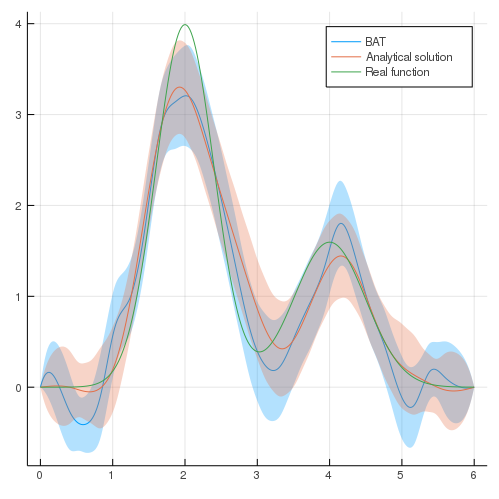

In [7]:
plot(x, phi_reconstructed_BAT, ribbon=phi_reconstructed_errors_BAT, fillalpha=0.3, label="BAT")
plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Analytical solution")
plot!(x, phi.(x), label="Real function")

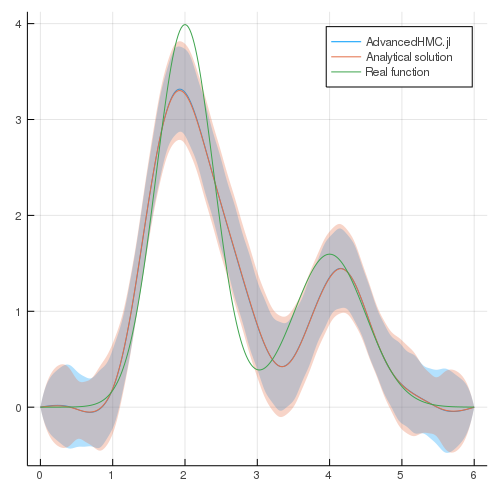

In [8]:
plot(x, phi_reconstructed_AHMC, ribbon=phi_reconstructed_errors_AHMC, fillalpha=0.3, label="AdvancedHMC.jl")
plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Analytical solution")
plot!(x, phi.(x), label="Real function")

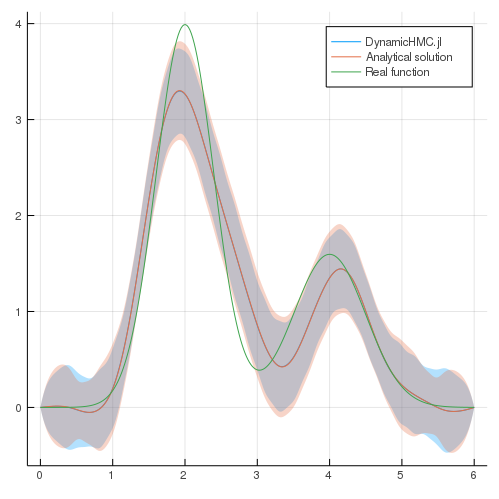

In [9]:
plot(x, phi_reconstructed_DHMC, ribbon=phi_reconstructed_errors_DHMC, fillalpha=0.3, label="DynamicHMC.jl")
plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Analytical solution")
plot!(x, phi.(x), label="Real function")